# UAS DEEP LEARNING (A2)
Cynthia Anne Ramali - 2702254032

Original File: https://www.kaggle.com/code/cynthiaanne/uas-dl-a2-cynthia-anne

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import glob
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

2025-06-28 07:29:58.938268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751095799.170635      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751095799.238328      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## a) EDA

In [2]:
file_dir = "/kaggle/input/uas-a-23/A_23"

In [3]:
img_ext = ['jpg']

clean_images_list = []
image_paths = []

for ext in img_ext:
    image_paths.extend(glob.glob(os.path.join(file_dir, f'*.{ext}')))

if not image_paths:
    print(f"Error: Tidak ada gambar yang ditemukan di folder '{file_dir}'.")
    exit()

print(f"Menemukan {len(image_paths)} gambar di folder '{file_dir}'.")

Menemukan 1074 gambar di folder '/kaggle/input/uas-a-23/A_23'.


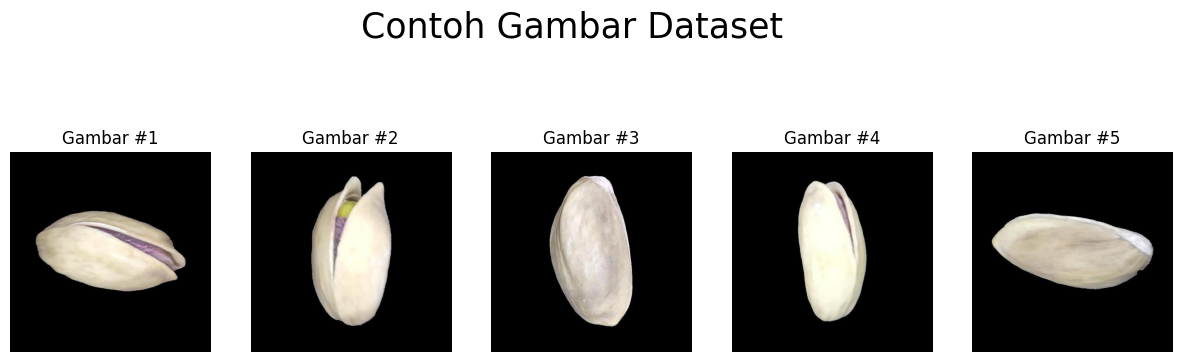

In [4]:
plt.figure(figsize=(15,5))
for i in range(5):
    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Gambar #{i+1}")
    plt.axis('off')

plt.suptitle('Contoh Gambar Dataset', fontsize=25)
plt.show()

## b) Data Preparation

### Split Data into Train, Val, and Test

In [5]:
train_data, temp_data = train_test_split(image_paths, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42
)

print(f"Train: {len(train_data)}")
print(f"Validation: {len(val_data)}")
print(f"Test: {len(test_data)}")

Train: 859
Validation: 107
Test: 108


### Resize Image & Normalization

In [8]:
img_size = 100

def process_images_from_paths(paths):
    images_list = []
    for path in paths:
        try:
            img = cv2.imread(path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (img_size, img_size))
            images_list.append(img_resized / 255.0)
            
        except Exception as e:
            print(f"Gagal memproses gambar {path}: {e}")
            
    return np.array(images_list).astype('float32')

In [9]:
y_train = process_images_from_paths(train_data)
y_val = process_images_from_paths(val_data)
y_test = process_images_from_paths(test_data)

print("\nBerhasil memproses gambar untuk setiap set.")
print(f"Shape y_train (clean): {y_train.shape}")
print(f"Shape y_val (clean): {y_val.shape}")
print(f"Shape y_test (clean): {y_test.shape}")


Berhasil memproses gambar untuk setiap set.
Shape y_train (clean): (859, 100, 100, 3)
Shape y_val (clean): (107, 100, 100, 3)
Shape y_test (clean): (108, 100, 100, 3)


### Create Noise Image (Gaussian)

In [10]:
def add_gaussian_noise(images, mean=0.0, std_dev=0.1):
    noise = np.random.normal(loc=mean, scale=std_dev, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    
    return noisy_images.astype('float32')

In [11]:
x_train = add_gaussian_noise(y_train)
x_val = add_gaussian_noise(y_val)
x_test = add_gaussian_noise(y_test)

print("\nBerhasil menambahkan noise.")
print(f"Shape x_train (noisy): {x_train.shape}")
print(f"Shape x_val (noisy): {x_val.shape}")
print(f"Shape x_test (noisy): {x_test.shape}")


Berhasil menambahkan noise.
Shape x_train (noisy): (859, 100, 100, 3)
Shape x_val (noisy): (107, 100, 100, 3)
Shape x_test (noisy): (108, 100, 100, 3)


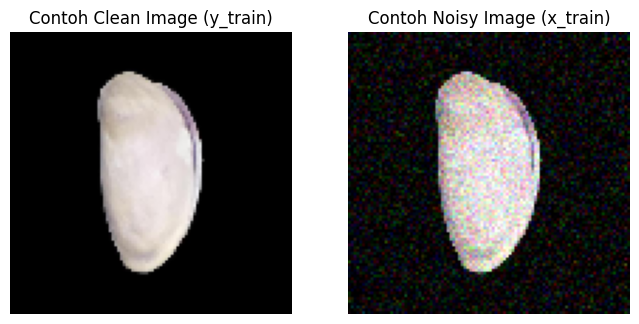

In [12]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(y_train[0])
plt.title("Contoh Clean Image (y_train)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_train[0])
plt.title("Contoh Noisy Image (x_train)")
plt.axis('off')

plt.show()

## c) Baseline Autoencoder Model

In [13]:
def build_baseline_model():
    input_img = Input(shape=(img_size, img_size, 3))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # Latent space

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)    
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder

In [14]:
baseline_model = build_baseline_model()
print("Architecture Baseline Model:")
baseline_model.summary()

Architecture Baseline Model:


2025-06-27 16:41:45.918203: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_baseline = baseline_model.fit(
    x_train, y_train,
    epochs=40,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val)
)

print("\nPelatihan model baseline selesai.")

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 726ms/step - loss: 0.1253 - val_loss: 0.0084
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 712ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 717ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 726ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 688ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 701ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 704ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 687ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 702ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 681ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 729ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 19

## d) Modified Autoencoder Model

In [16]:
def build_modified_model():
    input_img = Input(shape=(img_size, img_size, 3))
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder_modified = Model(input_img, decoded)
    autoencoder_modified.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder_modified

In [17]:
modified_model = build_modified_model()
print("Architecture Modificated Model:")
modified_model.summary()

Architecture Modificated Model:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,291 (298.01 KB)

 Trainable params: 75,971 (296.76 KB)

 Non-trainable params: 320 (1.25 KB)

In [18]:
early_stopping_modified = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [19]:
history_modified = modified_model.fit(
    x_train, y_train,
    epochs=40,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_modified]
)

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 954ms/step - loss: 0.0542 - val_loss: 0.0596
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 936ms/step - loss: 0.0039 - val_loss: 0.0221
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 960ms/step - loss: 0.0027 - val_loss: 0.0202
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 955ms/step - loss: 0.0023 - val_loss: 0.0225
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 918ms/step - loss: 0.0021 - val_loss: 0.0244
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 952ms/step - loss: 0.0019 - val_loss: 0.0236
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 946ms/step - loss: 0.0019 - val_loss: 0.0204
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 950ms/step - loss: 0.0017 - val_loss: 0.0179
Epoch 9/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 947ms/step - loss: 0.0016 - val_loss: 0.0136
Epoch 10/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 918ms/step - loss: 0.0015 - val_loss: 0.0116
Epoch 11/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 943ms/step - loss: 0.0015 - val_loss: 0.0086
Epoch 12/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 25

## e) Evaluasi Model

In [20]:
denoised_baseline = baseline_model.predict(x_test)
denoised_modified = modified_model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


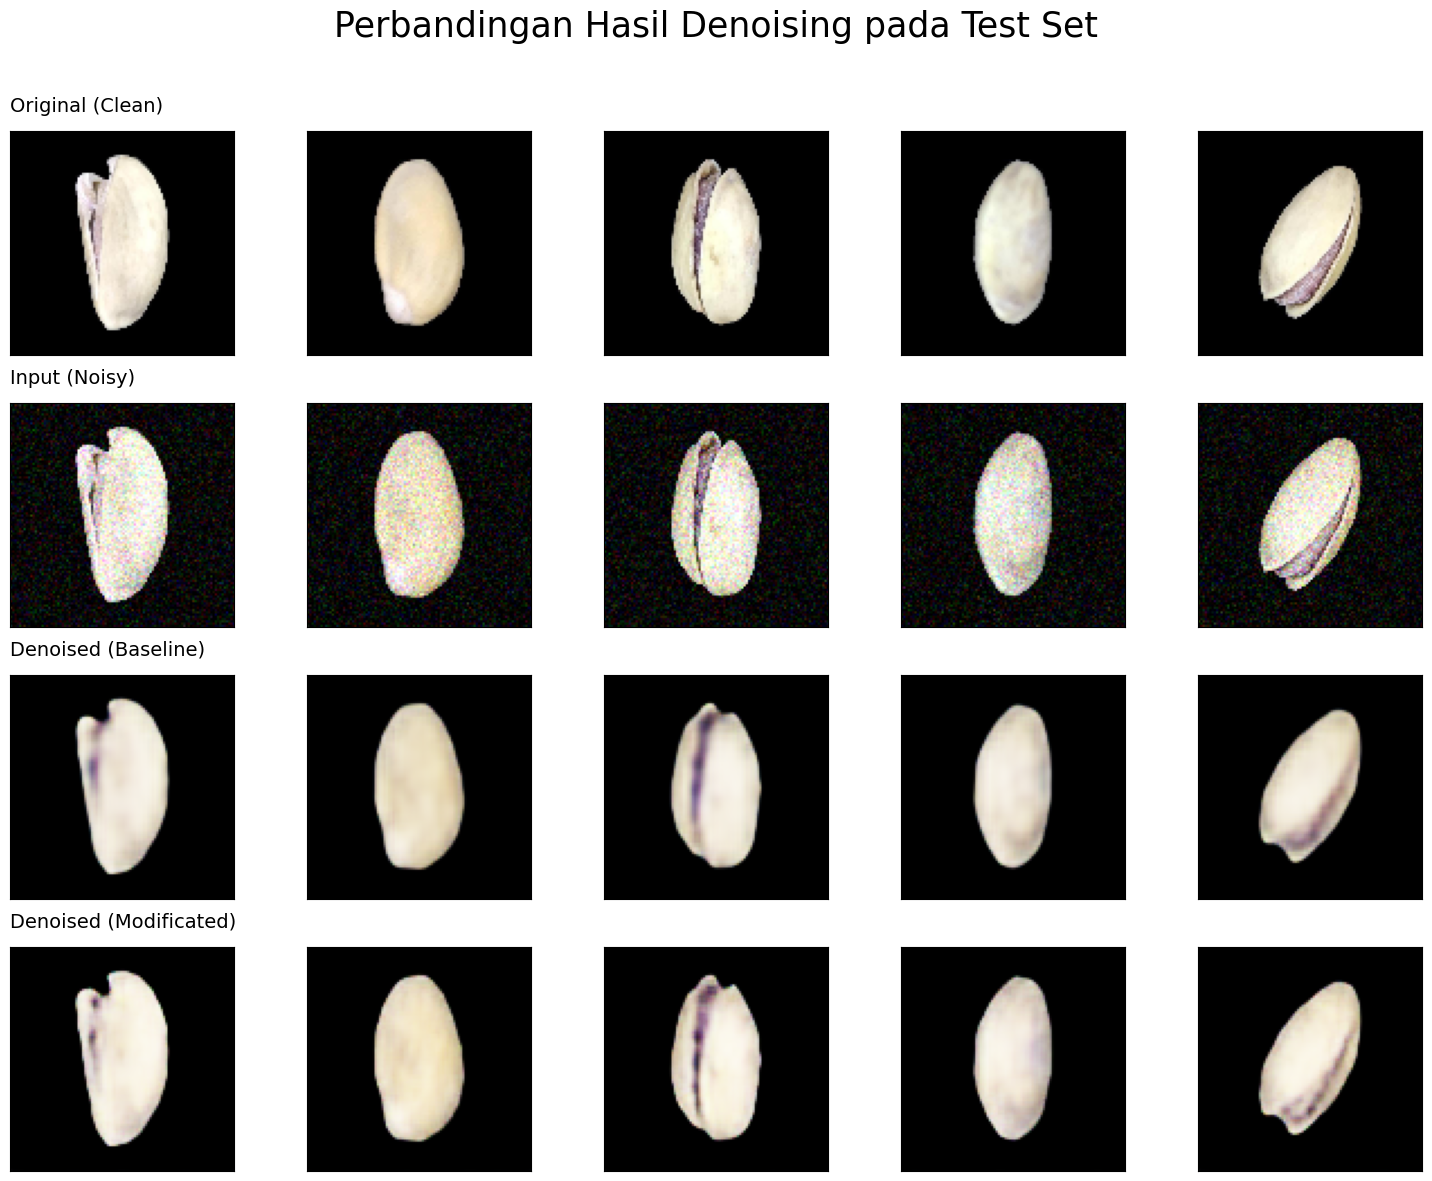

In [21]:
n_examples = 5
plt.figure(figsize=(15, 12))
plt.suptitle("Perbandingan Hasil Denoising pada Test Set", fontsize=25)

num_images_to_show = min(n_examples, len(x_test))

for i in range(num_images_to_show):
    # Clean
    ax = plt.subplot(4, n_examples, i + 1)
    plt.imshow(y_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original (Clean)", loc='left', fontsize=14, y=1.05)

    # Noise
    ax = plt.subplot(4, n_examples, i + 1 + n_examples)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Input (Noisy)", loc='left', fontsize=14, y=1.05)

    # Denoised (Baseline)
    ax = plt.subplot(4, n_examples, i + 1 + 2 * n_examples)
    plt.imshow(denoised_baseline[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ssim_score_baseline = ssim(y_test[i], denoised_baseline[i], channel_axis=-1, data_range=1.0)
        ax.set_title(f"Denoised (Baseline)", loc='left', fontsize=14, y=1.05)

    # Denoised (Modified)
    ax = plt.subplot(4, n_examples, i + 1 + 3 * n_examples)
    plt.imshow(denoised_modified[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ssim_score_modified = ssim(y_test[i], denoised_modified[i], channel_axis=-1, data_range=1.0)
        ax.set_title(f"Denoised (Modificated)", loc='left', fontsize=14, y=1.05)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

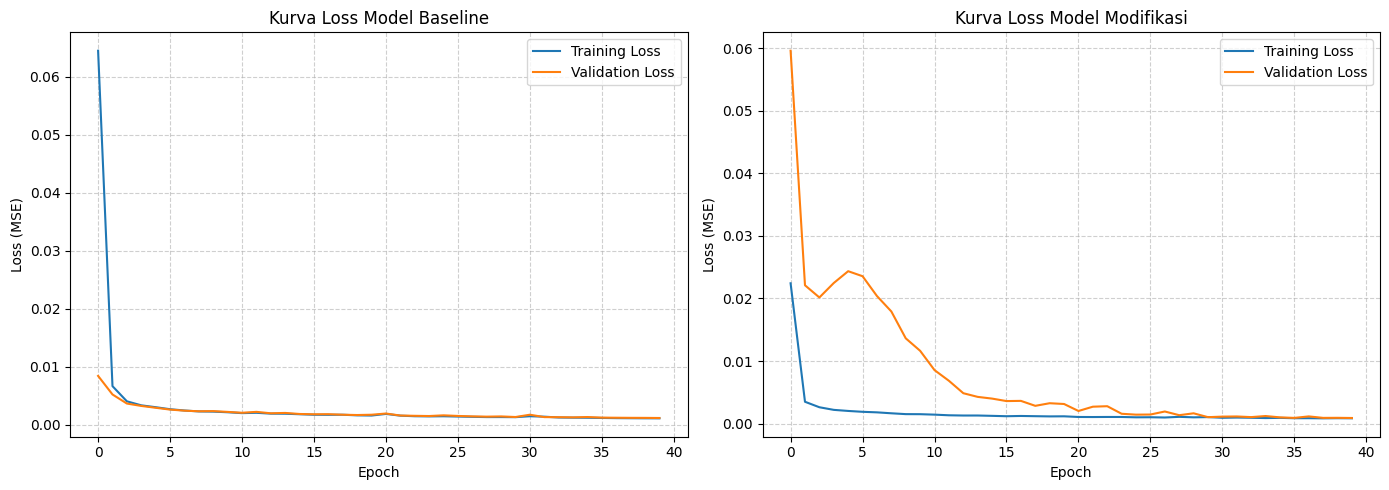

In [22]:
plt.figure(figsize=(14, 5))

# Baseline
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Kurva Loss Model Baseline')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# Modified
plt.subplot(1, 2, 2)
plt.plot(history_modified.history['loss'], label='Training Loss')
plt.plot(history_modified.history['val_loss'], label='Validation Loss')
plt.title('Kurva Loss Model Modificated')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [23]:
def calculate_avg_ssim(true_images, predicted_images):
    ssim_scores = []
    for i in range(len(true_images)):
        true_img = true_images[i].astype(float)
        pred_img = predicted_images[i].astype(float)
        score = ssim(true_img, pred_img, channel_axis=-1, data_range=1.0)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

In [24]:
ssim_baseline = calculate_avg_ssim(y_test, denoised_baseline)
ssim_modified = calculate_avg_ssim(y_test, denoised_modified)

print(f"SSIM Baseline Model: {ssim_baseline:.4f}")
print(f"SSIM Modificated Model: {ssim_modified:.4f}")

SSIM Baseline Model: 0.9430
SSIM Modificated Model: 0.9510


## f) Video Explanation

Link Google Drive: https://drive.google.com/file/d/194dsMNq8LIL-fj25wRVQ_tQ83E3HUtK1/view?usp=sharing